# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [19]:
!rm --f traffic-signs-data.zip
!wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
!unzip -o traffic-signs-data.zip -d data
!rm --f traffic-signs-data.zip

--2019-04-20 18:54:50--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 13.32.168.61, 13.32.168.234, 13.32.168.156, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|13.32.168.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip’

traffic-signs-data. 100%[===================>] 117.80M  6.80MB/s    in 17s     

2019-04-20 18:55:07 (7.08 MB/s) - ‘traffic-signs-data.zip’ saved [123524425/123524425]

Archive:  traffic-signs-data.zip
  inflating: data/test.p             
  inflating: data/train.p            
  inflating: data/valid.p            


In [3]:
import pickle
import numpy as np
import cv2
from sklearn.utils import shuffle
from plot import plot_images
from networks import simple_convnet

ImportError: Traceback (most recent call last):
  File "/home/n0tus/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow.py", line 41, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/n0tus/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/n0tus/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/n0tus/anaconda3/envs/carnd-term1/lib/python3.5/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/home/n0tus/anaconda3/envs/carnd-term1/lib/python3.5/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: libcusolver.so.8.0: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [29]:
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [22]:
n_train = len(X_train)

n_validation = len(X_valid)

n_test = len(X_test)

image_shape = X_train[0].shape

n_classes = max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
colors = ['#28535c', '#3b9250', '#ffa600'] # Color palette used for visualization

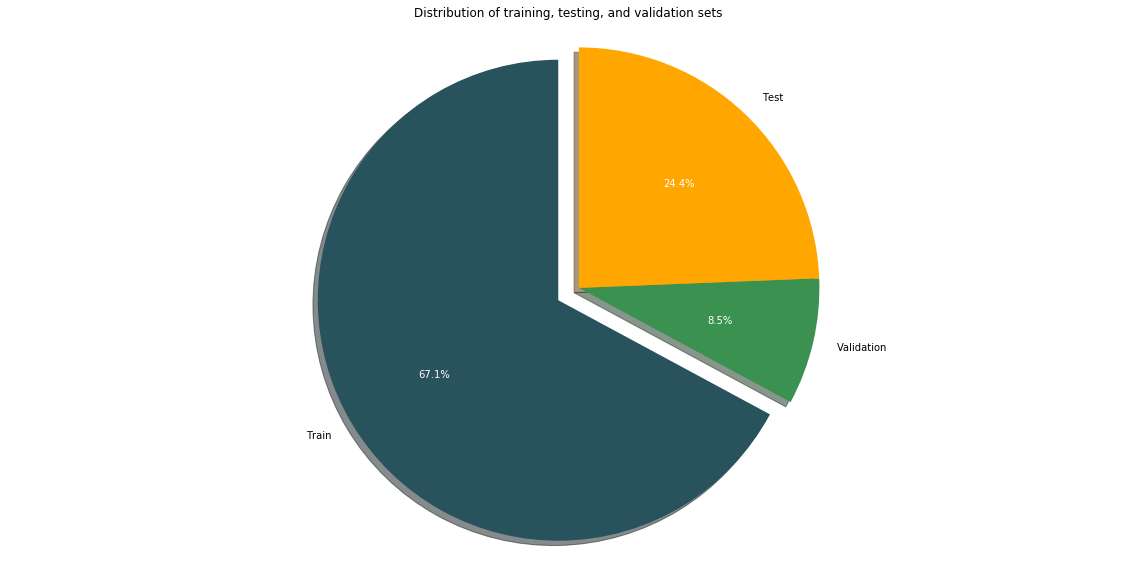

In [24]:
plt.figure(figsize=(20,10))
explode = (0.1, 0, 0)
_, _, autotexts = plt.pie([n_train, n_validation, n_test], startangle=90, autopct='%1.1f%%', explode=explode, labels=['Train', 'Validation', 'Test'], shadow=True, colors=colors)
for autotext in autotexts:
    autotext.set_color('white')
plt.axis("equal")
plt.title('Distribution of training, testing, and validation sets')
plt.show()

Usually the training and test set have a 70/30 ratio as a rule of thumb. The data comes broken up already and I don't think altering the current ratios would affect the results in a meaningful way.

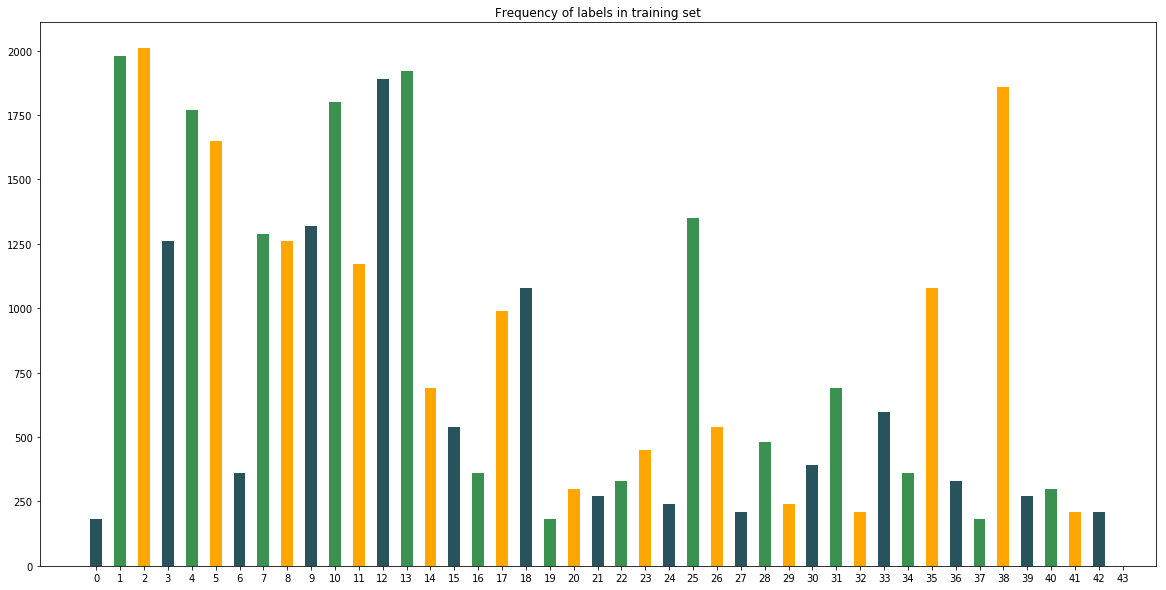

In [25]:
plt.figure(figsize=(20,10))
_, _, patches = plt.hist(y_train, color=colors[1], rwidth=0.5, bins=np.arange(44), align="left")

for index, p in enumerate(patches):
    plt.setp(p, 'facecolor', colors[index % 3])
plt.title('Frequency of labels in training set')
plt.xticks(np.arange(44))
plt.show()

Labels with high frequency in the training set might cause the network to generalize towards those features. One way this could be addressed is by evening out the frequencies a bit by increasing the frequency of low frequency labels by altering the images associated with them in different ways such as rotating. Let's run the model with the data as is first though to see what kind of improvements we get.

### Pre-process the Data Set (normalization, grayscale, etc.)

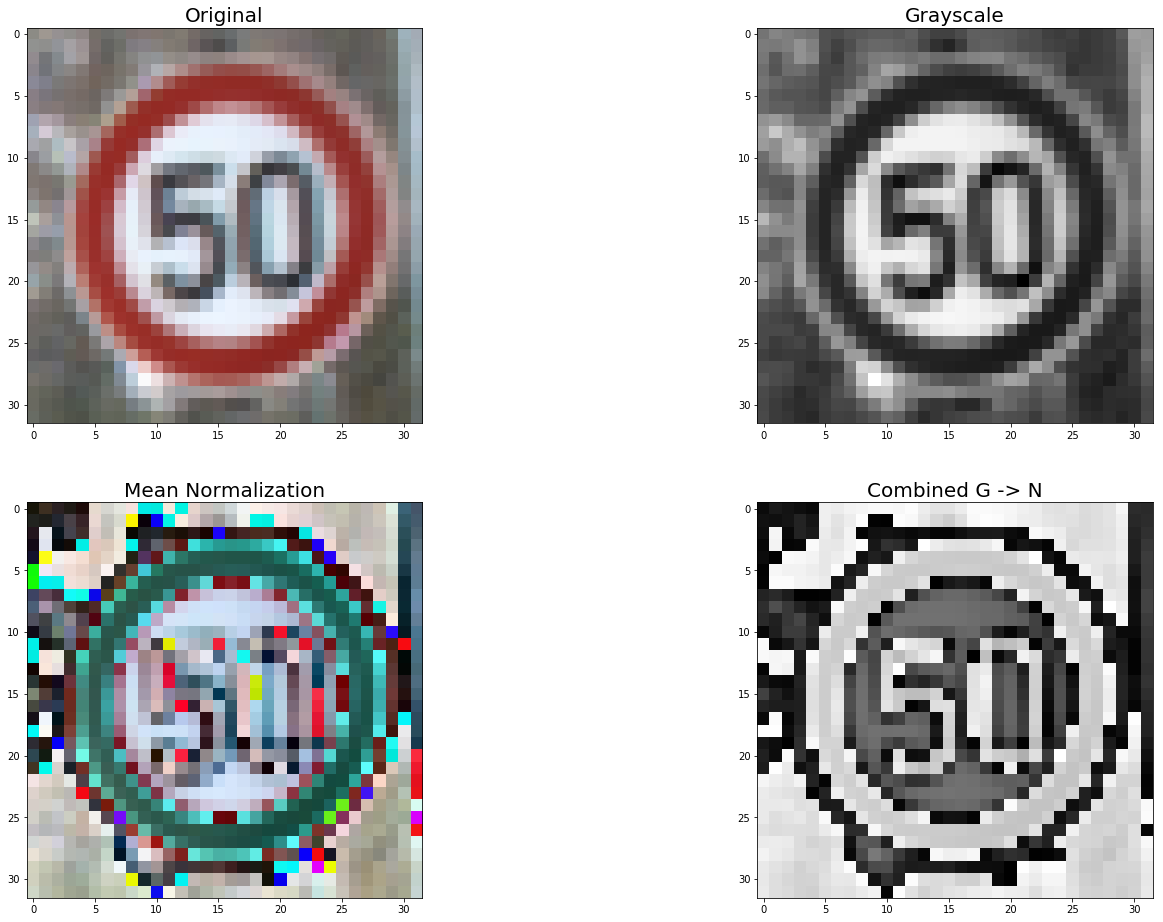

In [36]:
def normalize(img):
    return (img - 128) / 128

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

X_train, y_train = shuffle(X_train, y_train)

test_img = X_train[0]
gray_test = grayscale(test_img)
normalize_test = normalize(test_img)
combined_gray_first = normalize(gray_test)
image_set = [test_img, gray_test, normalize_test, combined_gray_first]
labels = ["Original", "Grayscale", "Mean Normalization", "Combined G -> N"]

plot_images(image_set, 2, labels)

In [27]:
X_train = [normalize(grayscale(x)) for x in X_train]

### Model Architecture   

I wanted to run some experiments on the efficacy of different model architectures for this problem. Below are the proposed architectures, note that all convolution layers have a stride of `n x n` unless otherwise noted:  

```
INPUT -> CONV -> RELU -> FC
```
```
INPUT -> [CONV -> RELU -> POOL] * 2 -> FC -> RELU -> FC
```
```
INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL] * 3 -> [FC -> RELU] * 2 -> FC
```
```
INPUT -> [CONV -> RELU -> CONV{STRIDE: 2n x 2n} -> RELU] * 2 -> FC -> RELU -> FC
```

The first 3 architectures are from the Stanford CS231 course (http://cs231n.github.io/convolutional-networks/). The last one is testing to see if we can get comparable results in both scoring and time to train by replacing the pooling with another convolutional layer with a larger stride. The *all convnet* approach was inspired by this paper (https://arxiv.org/abs/1412.6806).


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [11]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [12]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [13]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [14]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [15]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [16]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")